##### Grading Feedback Cell
102

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, isnull, when, count, col
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [5]:
# your code here
trans_df = spark.read.option("header","true").option("delimiter","\t").option("inferSchema","true").csv('MooresLaw.txt')
trans_df.show(5)
print('Shape = ',(trans_df.count(), len(trans_df.columns)))

+---------------+------+-----------+----+----+----+----+
|Intel Processor|  Year|Transistors| _c3| _c4| _c5| _c6|
+---------------+------+-----------+----+----+----+----+
|           4004|1971.9|       2300|null|null|null|null|
|           8008|1972.3|       3500|null|null|null|null|
|           8080|1974.3|       6000|null|null|null|null|
|           8085|1976.3|       6500|null|null|null|null|
|           8086|1978.5|      29000|null|null|null|null|
+---------------+------+-----------+----+----+----+----+
only showing top 5 rows

Shape =  (74, 7)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [6]:
# your code here
keep_col = ["Year","Transistors"]
new = [feature for feature in trans_df.columns if feature not in keep_col]
trans_df = trans_df.drop(*new)
trans_df.show()

+------+-----------+
|  Year|Transistors|
+------+-----------+
|1971.9|       2300|
|1972.3|       3500|
|1974.3|       6000|
|1976.3|       6500|
|1978.5|      29000|
|1979.5|      29000|
|1982.2|     134000|
|1985.8|     275000|
|1989.3|    1180000|
|1993.3|    3100000|
|1994.3|    1600000|
|1994.3|    3300000|
|1995.9|    5500000|
|1996.8|    4500000|
|1997.4|    7500000|
|1998.5|    7500000|
|1999.3|    9500000|
|1999.8|   28100000|
|2000.4|   28000000|
|2000.9|   42000000|
+------+-----------+
only showing top 20 rows



In [7]:
trans_df = trans_df.na.drop()


In [8]:

nan = trans_df.select(sum([count(when(isnan(c),c)).alias(c).cast('int') for c in trans_df.columns]).alias('nan_total'))
print('Total number of NaN values in trans_df =',nan.first()[0])

Total number of NaN values in trans_df = 0


In [46]:
trans_df.printSchema()

root
 |-- Year: double (nullable = true)
 |-- Transistors: long (nullable = true)



##### Grading Feedback Cell

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

Text(0.5, 1.0, 'Scatter plot of Year vs Number of Transistors')

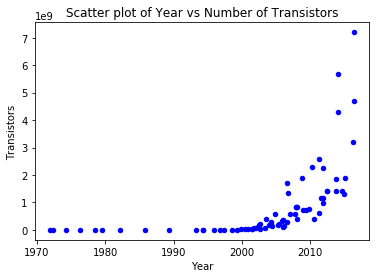

In [10]:
# Your code here
trans_df_scatter = trans_df.toPandas()

trans_df_scatter.plot.scatter(x="Year",y="Transistors",c="Blue")
plt.title("Scatter plot of Year vs Number of Transistors")

##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [11]:
# your code here
corr = trans_df.select([fn.corr('Year','Transistors').alias("Correlation Year vs No of Transistors")])
corr.show()

+-------------------------------------+
|Correlation Year vs No of Transistors|
+-------------------------------------+
|                   0.5434352929286356|
+-------------------------------------+



##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

Your correlation interpretation here:
The correlation between Year and Number of Transistors is 0.54 which is a moderately strong positive correlation. The strength of the correlation is moderately strong meaning the absolute value is high enough. The direction is positive meaning as the time progressed from 1970 to 2010, the number of transistors went very high increasing exponentially after 2000. This caused the devices to become smaller as the number of transistors that could be accomodated on a chip were very high. This also proves the Moore's Law is correct for the number of transistors so there is a exponential rise in the number of transistors as time passes by.

##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [12]:
# your code here

trans_df_2 = trans_df.select(trans_df["Year"],trans_df["Transistors"],fn.log(trans_df['Transistors']).alias('Log Transistors'))
print(trans_df_2.head())
print('Shape = ',(trans_df_2.count(), len(trans_df_2.columns)))

Row(Year=1971.9, Transistors=2300, Log Transistors=7.7406644019172415)
Shape =  (74, 3)


##### Grading Feedback Cell
-2 for not displaying the first 5 rows of the dataframe properly

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

Text(0.5, 1.0, 'Scatter plot of Year vs Log of Number of Transistors')

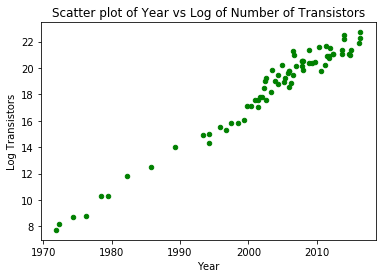

In [13]:
# your code here

trans_df_scatter_log = trans_df_2.toPandas()

trans_df_scatter_log.plot.scatter(x="Year",y="Log Transistors",c="Green")
plt.title("Scatter plot of Year vs Log of Number of Transistors")

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [14]:
# your code here
trans_train,trans_test = trans_df_2.randomSplit([0.6, 0.4],seed=124)

print('Shape of train dataframe =',(trans_train.count(), len(trans_train.columns)))
print('Shape of test dataframe =',(trans_test.count(), len(trans_test.columns)))

Shape of train dataframe = (47, 3)
Shape of test dataframe = (27, 3)


##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [15]:
# your code here

stage_1 = feature.VectorAssembler(inputCols=['Year'], outputCol='features')

stage_2 = regression.LinearRegression(featuresCol='features', labelCol='Transistors')

trans_pipe = Pipeline(stages=[stage_1, stage_2])

In [16]:
fitted_trans_pipe = trans_pipe.fit(trans_train) 

fitted_trans_pipe.transform(trans_test)

log_fitted_trans_pipe = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Year'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Log Transistors')]).fit(trans_train)

log_fitted_trans_pipe.transform(trans_test)

DataFrame[Year: double, Transistors: bigint, Log Transistors: double, features: vector, prediction: double]

In [17]:
fitted_trans_pipe.transform(trans_test).show(5)

log_fitted_trans_pipe.transform(trans_test).show(5)

+------+-----------+------------------+--------+--------------------+
|  Year|Transistors|   Log Transistors|features|          prediction|
+------+-----------+------------------+--------+--------------------+
|1982.2|     134000|11.805595078933049|[1982.2]|-2.95158795629165...|
|1989.3|    1180000|13.981024996441848|[1989.3]| 7.640210350820923E7|
|1993.3|    3100000|14.946912669455374|[1993.3]| 2.857321875292511E8|
|1997.4|    7500000|15.830413578506539|[1997.4]| 5.002955236508484E8|
|1999.3|    9500000| 16.06680235657077|[1999.3]| 5.997273135608368E8|
+------+-----------+------------------+--------+--------------------+
only showing top 5 rows

+------+-----------+------------------+--------+------------------+
|  Year|Transistors|   Log Transistors|features|        prediction|
+------+-----------+------------------+--------+------------------+
|1982.2|     134000|11.805595078933049|[1982.2]|11.293357481551539|
|1989.3|    1180000|13.981024996441848|[1989.3]|13.679946551541775|
|1993

##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [18]:
# your code here
print('Linear Regression Y intercept for Log Transistors =',log_fitted_trans_pipe.stages[1].intercept)
print('Linear Regression Coefficient for Log Transistors = ',log_fitted_trans_pipe.stages[1].coefficients)

Linear Regression Y intercept for Log Transistors = -655.0019741430418
Linear Regression Coefficient for Log Transistors =  [0.3361393056324253]


In [19]:
print('Linear Regression Y intercept = ',fitted_trans_pipe.stages[1].intercept)
print('Linear Regression Coefficient = ',fitted_trans_pipe.stages[1].coefficients)

Linear Regression Y intercept =  -104028681932.26277
Linear Regression Coefficient =  [52332521.00526365]


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [20]:
# your code here

mse = fn.mean((fn.col('Transistors') - fn.col('prediction'))**2).alias('mse')
fitted_trans_pipe.transform(trans_test).select(mse).show()

+--------------------+
|                 mse|
+--------------------+
|1.906236608241877...|
+--------------------+



In [21]:
mse_log = fn.mean((fn.col('Log Transistors') - fn.col('prediction'))**2).alias('mse_log')
log_fitted_trans_pipe.transform(trans_test).select(mse_log).show()


+-------------------+
|            mse_log|
+-------------------+
|0.40226530379164865|
+-------------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [22]:
# Your code here

yr = [1970.0,1980.0,1990.0,2000.0,2010.0]


yr_df = spark.createDataFrame([Row(Year = yr)])

yr_df = yr_df.withColumn('Year',explode('Year'))



predict_df = log_fitted_trans_pipe.transform(yr_df).select("Year","features","prediction")

predict_df = predict_df.select(predict_df.Year,predict_df.features,exp(predict_df.prediction).alias("Number of Transistors"))

predict_df.show()

NameError: name 'explode' is not defined

##### Grading Feedback Cell
-5 runtime error

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [23]:
# your code here
global_warm_df = spark.read.option("header","true").option("delimiter","\t").option("inferSchema","true").csv('globalWarm.txt')

In [24]:
global_warm_df.show(5)
print('Shape =',(global_warm_df.count(), len(global_warm_df.columns)))

+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43| 0.928466667|     7.2|
|1980|  19|338.57|1366.51| 0.929666667|    7.85|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|
|1982|   4| 341.3|1366.16| 0.853066667|    7.45|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|
+----+----+------+-------+------------+--------+
only showing top 5 rows

Shape = (32, 6)


In [25]:
global_warm_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Temp: integer (nullable = true)
 |-- CO2: double (nullable = true)
 |-- Solar: double (nullable = true)
 |-- Transmission: double (nullable = true)
 |-- IceShelf: double (nullable = true)



##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

Text(0.5, 1.0, 'Global Warming depicted by scatter plot of Temprature vs Year')

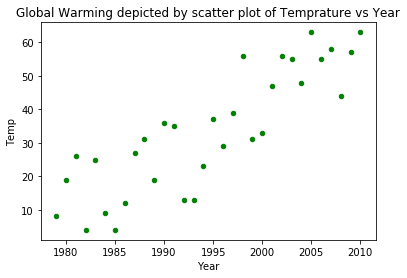

In [26]:
# your code here

global_warm_df_scatter = global_warm_df.toPandas()

global_warm_df_scatter.plot.scatter(x="Year",y="Temp",c="Green")
plt.title("Global Warming depicted by scatter plot of Temprature vs Year")

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

Text(0.5, 1.01, ' Pair plot of Temp, CO2, Solar, Transmission, IceShelf for GLobal Warming')

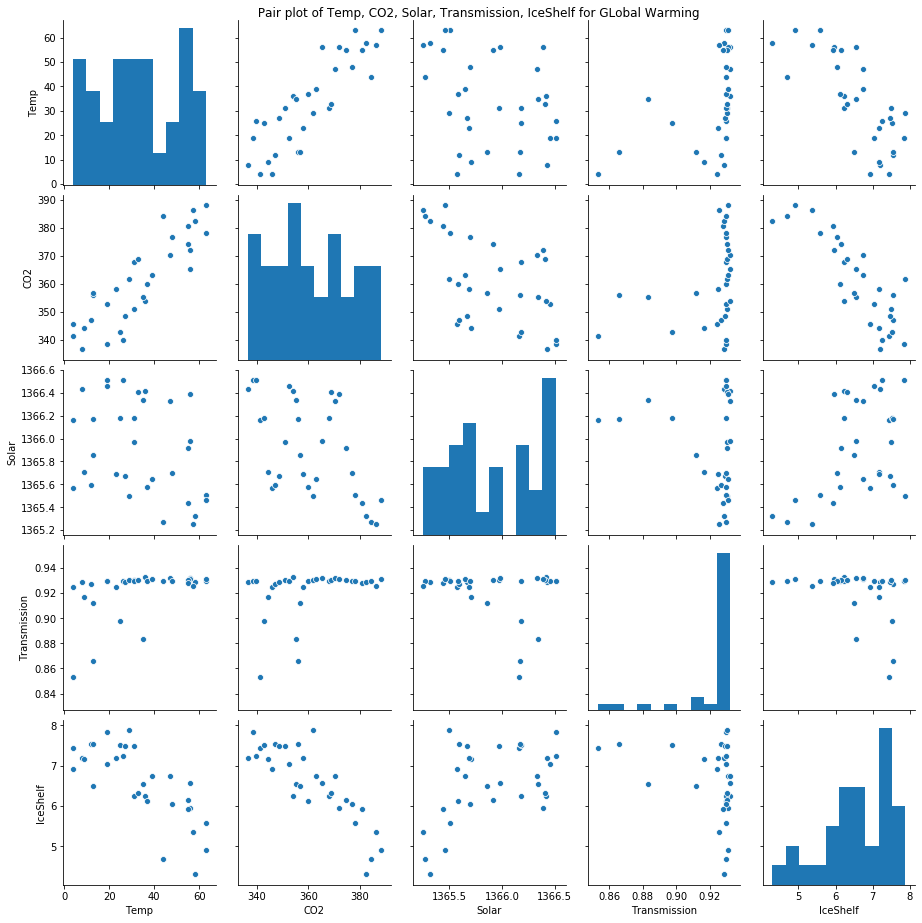

In [27]:
# your code here
global_warm_pairplot = sns.pairplot(global_warm_df.toPandas()[['Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf']])
global_warm_pairplot.fig.suptitle(" Pair plot of Temp, CO2, Solar, Transmission, IceShelf for GLobal Warming", y=1.01)

##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [28]:
corr_matrix = ["Temp","CO2","Solar","Transmission","IceShelf"]
vec = VectorAssembler(inputCols=corr_matrix,outputCol="features")
mat = vec.transform(global_warm_df).select("features")

matrix = Correlation.corr(mat, "features")

cor_mat = matrix.collect()[0]["pearson(features)"].values

corr_mat = pd.DataFrame(cor_mat.reshape(5,5),columns = corr_matrix, index=corr_matrix)

print(corr_mat)

                  Temp       CO2     Solar  Transmission  IceShelf
Temp          1.000000  0.860927 -0.340342      0.435394 -0.747425
CO2           0.860927  1.000000 -0.542822      0.328228 -0.846961
Solar        -0.340342 -0.542822  1.000000     -0.205848  0.470690
Transmission  0.435394  0.328228 -0.205848      1.000000 -0.302484
IceShelf     -0.747425 -0.846961  0.470690     -0.302484  1.000000


##### Grading Feedback Cell

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [29]:
# your code here

gw_train,gw_test = global_warm_df.randomSplit([0.6, 0.4],seed=128)

print('Shape of train data = ',(gw_train.count(), len(gw_train.columns)))
print('Shape of test data = ',(gw_test.count(), len(gw_test.columns)))

Shape of train data =  (18, 6)
Shape of test data =  (14, 6)


##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [30]:
# your code here

stage_1 = feature.VectorAssembler(inputCols=['CO2'], outputCol='features')

stage_2 = regression.LinearRegression(featuresCol='features', labelCol='Temp')

global_warm_pipe = Pipeline(stages=[stage_1, stage_2])

In [31]:
fitted_global_warm_pipe = global_warm_pipe.fit(gw_train)

fitted_global_warm_pipe.transform(gw_test).show()

+----+----+------+-------+------------+--------+--------+------------------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|features|        prediction|
+----+----+------+-------+------------+--------+--------+------------------+
|1980|  19|338.57|1366.51| 0.929666667|    7.85|[338.57]| 8.924623636759577|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|[339.92]|10.327008389273203|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|[342.71]|13.225270211134557|
|1984|   9|344.24|1365.71| 0.916491667|    7.17|[344.24]| 14.81463959731667|
|1985|   4|345.81|1365.57|    0.924425|    6.93|[345.81]| 16.44556112431394|
|1986|  12|347.11|1365.59| 0.926791667|    7.54|[347.11]|17.796005700808507|
|1994|  23|358.14|1365.69| 0.924691667|    7.18|[358.14]|29.254008530604608|
|1997|  39|363.18|1365.65|    0.930975|    6.74|[363.18]|34.489578273322024|
|1998|  56|365.19|1365.98|    0.932125|    6.56|[365.19]|36.577573349286695|
|1999|  31|367.86|1366.18| 0.929616667|    6.24|[367.86]|39.351178748702466|

In [32]:
fitted_global_warm_pipe_2 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['CO2', 'Transmission', 'Solar','IceShelf'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Temp')  
]).fit(gw_train)

In [33]:
fitted_global_warm_pipe_2.transform(gw_test).show()

+----+----+------+-------+------------+--------+--------------------+------------------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|            features|        prediction|
+----+----+------+-------+------------+--------+--------------------+------------------+
|1980|  19|338.57|1366.51| 0.929666667|    7.85|[338.57,0.9296666...|13.016039926225176|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|[339.92,0.9297666...|15.360019706544563|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|[342.71,0.8977166...|11.885098848538973|
|1984|   9|344.24|1365.71| 0.916491667|    7.17|[344.24,0.9164916...| 16.60970547875081|
|1985|   4|345.81|1365.57|    0.924425|    6.93|[345.81,0.924425,...|19.597702786177024|
|1986|  12|347.11|1365.59| 0.926791667|    7.54|[347.11,0.9267916...| 19.86825229631654|
|1994|  23|358.14|1365.69| 0.924691667|    7.18|[358.14,0.9246916...| 29.58557284246467|
|1997|  39|363.18|1365.65|    0.930975|    6.74|[363.18,0.930975,...|35.681892258158314|
|1998|  56|365.19|136

##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [34]:
# your code here
print('Linear regression Y intercept = ',fitted_global_warm_pipe.stages[1].intercept)
print('Linear Regression coefficient = ',fitted_global_warm_pipe.stages[1].coefficients)

Linear regression Y intercept =  -342.78308425844295
Linear Regression coefficient =  [1.0388035203804311]


In [35]:
print('Linear regression Y intercept for all variables except Year = ',fitted_global_warm_pipe_2.stages[1].intercept)
print('Linear regression coefficients for all variables except Year = ',fitted_global_warm_pipe_2.stages[1].coefficients)

Linear regression Y intercept for all variables except Year =  -1136.728962684678
Linear regression coefficients for all variables except Year =  [0.8416578548749342,159.43928385390151,0.5357825425921865,-1.986329579754835]


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [36]:
# your code here
mse = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse')

In [37]:
print("MSE for only CO2 as independent variable")
fitted_global_warm_pipe.transform(gw_test).select(mse).show()

MSE for only CO2 as independent variable
+------------------+
|               mse|
+------------------+
|103.52444226883516|
+------------------+



In [38]:
print("MSE for all variables except Year as independent variable")
fitted_global_warm_pipe_2.transform(gw_test).select(mse).show()

MSE for all variables except Year as independent variable
+-----------------+
|              mse|
+-----------------+
|97.11228539908862|
+-----------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

The MSE for model where all the parameters except Year is taken as Independent Variables to predict Temp is lower. The difference in Predicted Value and the actual value is less when all the variables are included together. For this model, the effect of all independent variables on Temp is predicted rather than using only 1 or combination of 1 with Temp on a repetative basis. This model captures the effect all variables together as a whole not isolating one from another. This model which has many independent variables has a low variance in terms of distance between the actual and predicted values is less. So this model is better as it accounts for all factors and the MSE is also lower.

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [39]:
# your code here

va = feature.VectorAssembler(inputCols=['CO2', 'Transmission', 'Solar','IceShelf'], outputCol='features')
sc = feature.StandardScaler(withMean=True,withStd=True, inputCol='features',outputCol='scaled_features')
lr = regression.LinearRegression(featuresCol='scaled_features',labelCol='Temp')
fitted_global_warm_pipe_3 = Pipeline(stages=[va, sc, lr]).fit(gw_train)

In [40]:
fitted_global_warm_pipe_3.transform(gw_test).show()

+----+----+------+-------+------------+--------+--------------------+--------------------+------------------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|            features|     scaled_features|        prediction|
+----+----+------+-------+------------+--------+--------------------+--------------------+------------------+
|1980|  19|338.57|1366.51| 0.929666667|    7.85|[338.57,0.9296666...|[-1.5539672270010...| 13.01603992590881|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|[339.92,0.9297666...|[-1.4680110602483...|15.360019706168764|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|[342.71,0.8977166...|[-1.2903683156261...|11.885098848807349|
|1984|   9|344.24|1365.71| 0.916491667|    7.17|[344.24,0.9164916...|[-1.1929513266397...| 16.60970547999062|
|1985|   4|345.81|1365.57|    0.924425|    6.93|[345.81,0.924425,...|[-1.0929874882680...|19.597702787655553|
|1986|  12|347.11|1365.59| 0.926791667|    7.54|[347.11,0.9267916...|[-1.0102148832469...|19.868252297691207|
|1994|  23

In [41]:
print("Scaled_data_pipeline_intercept = {}".format(fitted_global_warm_pipe_3.stages[-1].intercept))
print("Scaled_data_pipeline_CO2_slope_coefficients = {}".format(fitted_global_warm_pipe_3.stages[-1].coefficients[0]))
print("Scaled_data_pipeline_Transmission_slope_coefficients = {}".format(fitted_global_warm_pipe_3.stages[-1].coefficients[1]))
print("Scaled_data_pipeline_Solar_slope_coefficients = {}".format(fitted_global_warm_pipe_3.stages[-1].coefficients[2]))
print("Scaled_data_pipeline_IceShelf_slope_coefficients = {}".format(fitted_global_warm_pipe_3.stages[-1].coefficients[3]))

Scaled_data_pipeline_intercept = 34.27777777777777
Scaled_data_pipeline_CO2_slope_coefficients = 13.21880845723335
Scaled_data_pipeline_Transmission_slope_coefficients = 3.888949613731317
Scaled_data_pipeline_Solar_slope_coefficients = 0.24195334026979165
Scaled_data_pipeline_IceShelf_slope_coefficients = -2.136427295105882


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

Coefficient inference conclusions here: The StandardScaler is used to normalize the feature coefficients. StandardScaler is required to bring all the coefficients to the same scale for the model to perform better for feature with variety of scales. Without Scaling, the model may treat variables with higher coefficients to be more important only because the value of coefficient is very large. So standard scaler scales data to use Standard Deviation and Mean of the data using withMean and withStd True in hand. The Values of intercept and slope coefficients for the multiple regression models with StandardScaler has coefficients in the same range for all variables which was not the case earlier, one was in 1000's,one in 100's and others in 1's or 10's. Earlier intercept was -16819 which after scaling came to 32 and all the variables slope coefficients also came in the same range. The intercept along with all the slope coefficients of all independent variables except Year are positive and in the same direction which means increase in any of these independent variables would result in increase in the Temperature. When all the variables are set to 0, the temperature is 32. Increase in 1 unit of CO2 will result in increase in temperature by 18 units keeping all the other independent variables constant.Increase in 1 unit of Transmission will result in increase in temperature by 2 units keeping all the other independent variables constant. Increase in 1 unit of Solar will result in increase in temperature by 4.5 units keeping all the other independent variables constant. Increase in 1 unit of IceShelf will result in increase in temperature by 2 units keeping all the other independent variables constant.

##### Grading Feedback Cell
-1: Increase in 1 unit of IceShelf will result in a decrease in temperature by 2 units keeping all the other independent variables constant.

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [42]:
# your code here
import numpy as np

# define our own simple as possible rdd class
class rdd:
    def __init__(self, arg_array):
        self.local_array = arg_array
    
    # define our own map function
    def my_map(self, fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        
        # create a new numpy array to hold the result
        # remember that rdd's are supposed to be immutable
        mapped = []
        
        # for each element in the local array
        for i, el in enumerate(self.local_array):
            # execute the user defined function on this element
            
            mapped.extend([fun(self.local_array[i])])
            
        # This is the key to how the data is passed.  The return value is another rdd object!
        # The fact that we are returning a new rdd is the key to how chaining works
        # create a new rdd using the array created by applying the user defined function
        return rdd(mapped)
    
    def my_filter(self, fun):
        # create a temporary list to store the filtered results
        transformed = []

        for el in self.local_array:
            if fun(el):
                transformed.append(el)
                
        return rdd(np.array(transformed))
    
    def my_reduce(self,fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
            
        
        result_arr = self.local_array[0]
        i=1
        while(i<len(self.local_array)):
            result_arr = fun(result_arr,self.local_array[i])
            i +=1
        
        return result_arr
    
    def collect(self):
        return self.local_array

def times_3(e):
    return e*3

def is_even(e):
    if e % 2 == 0:
        return True
    else:
        return False

def my_sum(e1,e2):
    return e1+e2

In [43]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)
# secret grading test code follows


<class 'numpy.int64'>
7350


##### Grading Feedback Cell